In [2]:
import os, random
import numpy as np
import pandas as pd
import seaborn as sns
import skimage.io as io
from skimage.transform import resize

import matplotlib.pyplot as plt
from matplotlib import ticker

%matplotlib inline 

from keras.models import Sequential
from keras.layers import Input, Dropout, Flatten, Convolution2D, MaxPooling2D, Dense, Activation
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import np_utils

In [3]:
TRAIN_DIR = 'train/'
TEST_DIR = 'test/'

ROWS = 64
COLS = 64
CHANNELS = 3

np.random.seed(10); random.seed(10)

train_images = [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR)]
train_cats =   [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR) if 'cat' in i] # 12.5 K cats
train_dogs =   [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR) if 'dog' in i] # 12.5 K dogs
test_images =  [TEST_DIR+i for i in os.listdir(TEST_DIR)]

# slice datasets for memory efficiency on Kaggle Kernels, delete if using full dataset
train_images = train_dogs[:1000] + train_cats[:1000]
random.shuffle(train_images)
test_images =  test_images[:50]

def read_image(file_path):
    img = io.imread(file_path)
    return resize(img, (ROWS, COLS))

def prep_data(images):
    count = len(images)
    data = np.ndarray((count, CHANNELS, ROWS, COLS), dtype=np.uint8)
    def process(idx, im_name):
        if idx == count-1:
            print('Finished Processing {} of {}'.format(idx+1, count))
        elif idx %250 == 0: 
            print('Processed {} of {}'.format(idx, count))
        data[idx] = np.array(read_image(im_name).T * 256, dtype=np.uint8)
    for idx, im_name in enumerate(images):
        process(idx, im_name)
    return data

train = prep_data(train_images)
test = prep_data(test_images)

print("Train shape: {}".format(train.shape))
print("Test shape: {}".format(test.shape))

Processed 0 of 2000
Processed 250 of 2000
Processed 500 of 2000
Processed 750 of 2000
Processed 1000 of 2000
Processed 1250 of 2000
Processed 1500 of 2000
Processed 1750 of 2000
Finished Processing 2000 of 2000
Processed 0 of 50
Finished Processing 50 of 50
Train shape: (2000, 3, 64, 64)
Test shape: (50, 3, 64, 64)


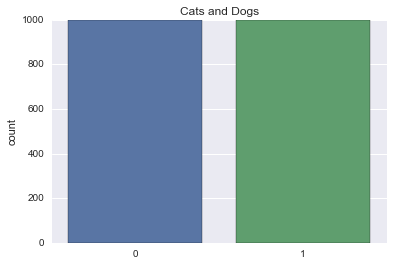

In [4]:
labels = []
for i in train_images:
    if 'dog' in i:
        labels.append(1)
    else:
        labels.append(0)

sns.countplot(labels)
sns.plt.title('Cats and Dogs')

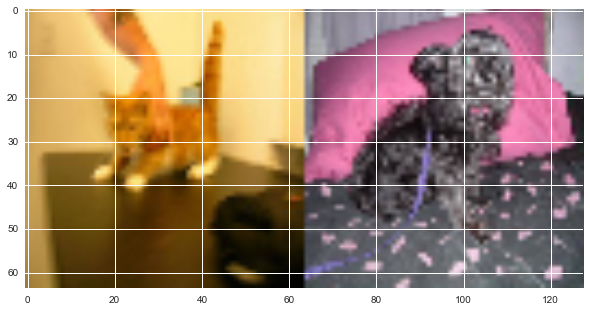

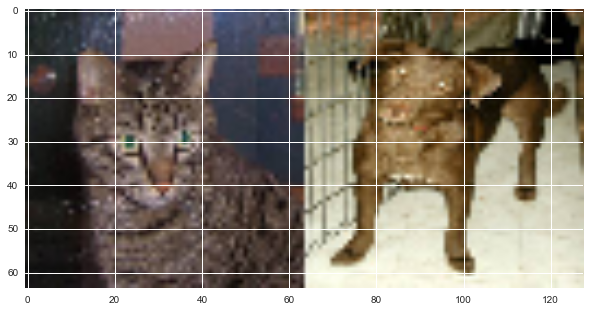

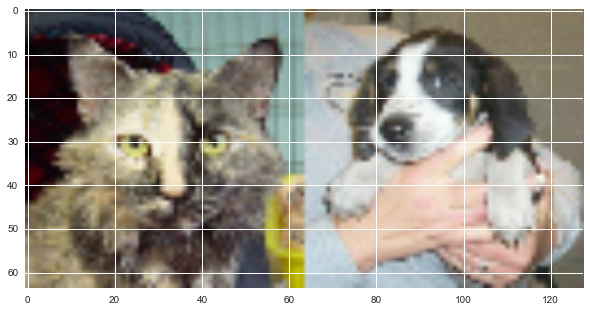

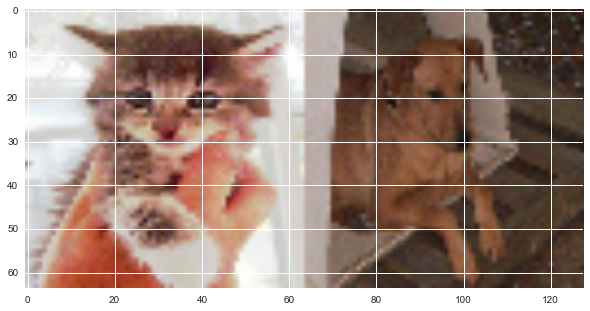

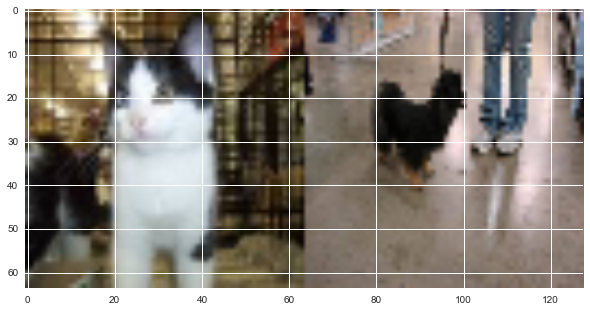

In [5]:
def show_cats_and_dogs(idx):
    cat = read_image(train_cats[idx])
    dog = read_image(train_dogs[idx])
    pair = np.concatenate((cat, dog), axis=1)
    plt.figure(figsize=(10,5))
    plt.imshow(pair)
    plt.show()
    
for idx in range(0,5):
    show_cats_and_dogs(idx)

In [6]:
optimizer = RMSprop(lr=1e-4)
objective = 'binary_crossentropy'

def catdog():
    
    model = Sequential()

    model.add(Convolution2D(32, 3, 3, border_mode='same', input_shape=(3, ROWS, COLS), dim_ordering='th', activation='relu'))
    model.add(Convolution2D(32, 3, 3, border_mode='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Convolution2D(64, 3, 3, border_mode='same', activation='relu'))
    model.add(Convolution2D(64, 3, 3, border_mode='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Convolution2D(128, 3, 3, border_mode='same', activation='relu'))
    model.add(Convolution2D(128, 3, 3, border_mode='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Convolution2D(256, 3, 3, border_mode='same', activation='relu'))
    model.add(Convolution2D(256, 3, 3, border_mode='same', activation='relu'))
#   model.add(Convolution2D(256, 3, 3, border_mode='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
#   model.add(Convolution2D(256, 3, 3, border_mode='same', activation='relu'))
#   model.add(Convolution2D(256, 3, 3, border_mode='same', activation='relu'))
#   model.add(Convolution2D(256, 3, 3, border_mode='same', activation='relu'))
#   model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    model.compile(loss=objective, optimizer=optimizer, metrics=['accuracy'])
    return model

model = catdog()

In [17]:
nb_epoch = 20
batch_size = 16

## Callback for loss logging per epoch
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []
        
    def on_epoch_end(self, batch, logs={}):
        print("Epoch ended")
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))

early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')        
        
def run_catdog():
    
    history = LossHistory()
    model.fit(train, labels, batch_size=batch_size, nb_epoch=nb_epoch,
              validation_split=0.25, verbose=0, shuffle=True, callbacks=[history, early_stopping])
    

    predictions = model.predict(test, verbose=0)
    return predictions, history

predictions, history = run_catdog()

Epoch ended
Epoch ended
Epoch ended
Epoch ended
Epoch ended
Epoch ended
Epoch ended
Epoch ended
Epoch ended
Epoch ended
Epoch ended
Epoch ended
Epoch 00011: early stopping


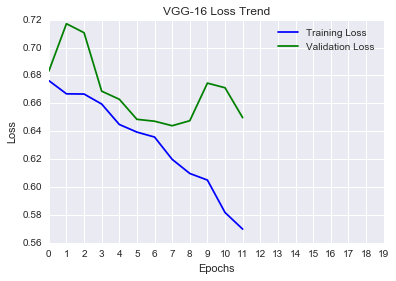

In [18]:
loss = history.losses
val_loss = history.val_losses

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('VGG-16 Loss Trend')
plt.plot(loss, 'blue', label='Training Loss')
plt.plot(val_loss, 'green', label='Validation Loss')
plt.xticks(range(0,nb_epoch)[:])
plt.legend()
plt.show()

I am 89.30% sure this is a Cat


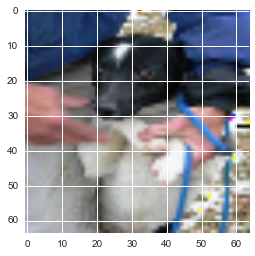

I am 75.91% sure this is a Cat


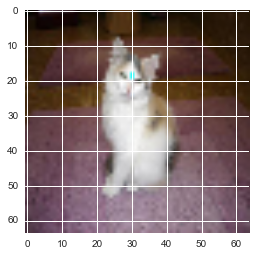

I am 91.34% sure this is a Cat


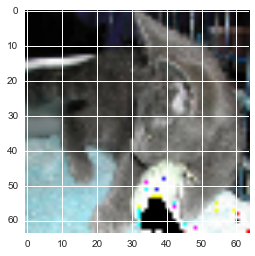

I am 71.41% sure this is a Dog


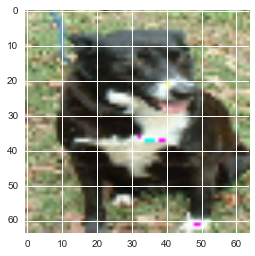

I am 57.49% sure this is a Dog


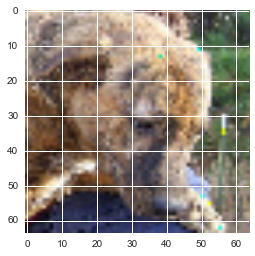

I am 99.72% sure this is a Cat


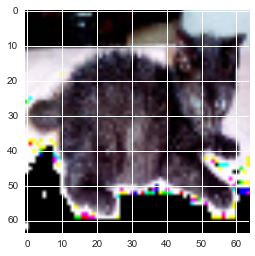

I am 58.07% sure this is a Dog


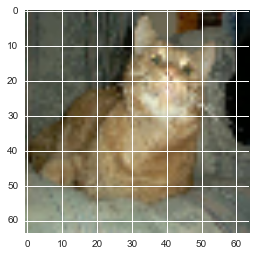

I am 76.99% sure this is a Dog


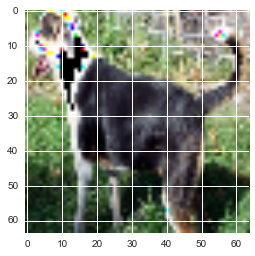

I am 51.60% sure this is a Cat


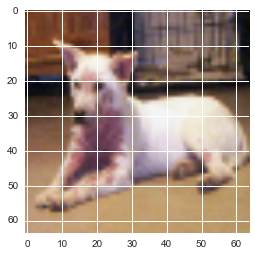

I am 83.66% sure this is a Cat


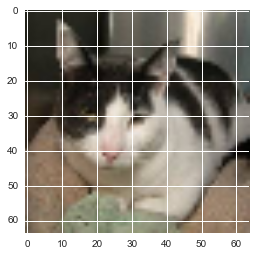

In [19]:
for i in range(0,10):
    if predictions[i, 0] >= 0.5: 
        print('I am {:.2%} sure this is a Dog'.format(predictions[i][0]))
    else: 
        print('I am {:.2%} sure this is a Cat'.format(1-predictions[i][0]))
        
    plt.imshow(test[i].T)
    plt.show()

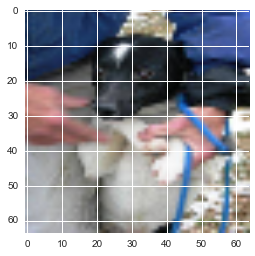

In [10]:
image = read_image(test_images[0])
plt.imshow(image)
plt.show()

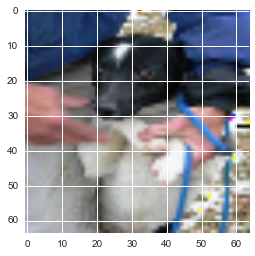

In [11]:
plt.imshow(test[0].T)
plt.show()

In [12]:
np.histogram(image[:,:,0])

(array([450, 794, 368, 195, 279, 395, 665, 522, 258, 170]),
 array([ 0.00388112,  0.10349301,  0.20310489,  0.30271678,  0.40232867,
         0.50194056,  0.60155245,  0.70116434,  0.80077622,  0.90038811,  1.        ]))

In [13]:
np.histogram(test[0].T)

(array([ 827, 1698, 1259, 1295, 1448, 1415, 1852, 1398,  620,  476]),
 array([   0. ,   25.5,   51. ,   76.5,  102. ,  127.5,  153. ,  178.5,
         204. ,  229.5,  255. ]))

In [20]:
scores = model.evaluate(train, labels, verbose=0)
print(scores)

[0.5474548940658569, 0.73150000000000004]


In [23]:
print("%s: %.2f" % (model.metrics_names[0], scores[0]*100))
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

loss: 54.75
acc: 73.15%


In [25]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk
